In [1]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
import torchvision
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

import torch.nn.functional as F

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

# Load Data and Preprocessing 

In [2]:
os.getcwd()

'c:\\Users\\Jijimon\\Desktop\\stat 453 final\\Stat-453-Chest-X-ray-Data'

In [3]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]

dataset_path = '.\\Combined_data' 

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])



In [4]:
def train_val_dataset(dataset):
    num = np.arange(len(dataset))
    np.random.shuffle(num)
    
    train_idx, test_idx, val_idx =  np.split(num, [int(.8*len(dataset)), int(.9*len(dataset))]) ###len(dataset) didn't work -> 21165
    
    return train_idx, test_idx, val_idx


#train - test - validation split
test_dataset = ImageFolder(dataset_path, transform= test_transforms)
train_dataset = ImageFolder(dataset_path, transform= train_transforms)
train_idx, test_idx, val_idx = train_val_dataset(test_dataset)

test_data = Subset(test_dataset, test_idx)
train_data = Subset(train_dataset, train_idx)
val_data = Subset(train_dataset, val_idx)

#loading data
test_loader = DataLoader(test_data, 64, shuffle = True)
train_loader = DataLoader(train_data, 64, shuffle = True)
valid_loader = DataLoader(val_data, 64, shuffle = True)


# Display Images

before transform
actual labels: ['Normal', 'Lung_Opacity', 'COVID', 'Lung_Opacity']
numerical labels: tensor([2, 1, 0, 1])


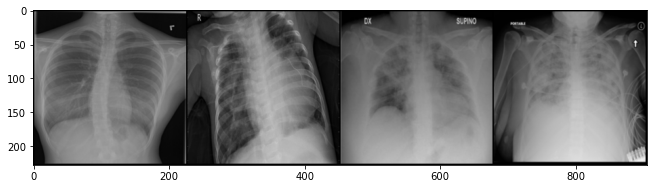

In [6]:
def convert_lab(lab):
    label_dc = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
    return [label_dc[int(i)] for i in list(lab)]

def show_img(data):
    loader = DataLoader(data, 4, shuffle = True)

    batch = next(iter(loader))
    img, lab = batch

    grid = torchvision.utils.make_grid(img, nrow=4)
    plt.figure(figsize = (11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    
    print(f'actual labels: {convert_lab(lab)}')
    print(f'numerical labels: {lab}')

###################################
print('before transform')
show_img(ImageFolder(dataset_path, transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
test data
actual labels: ['Lung_Opacity', 'Lung_Opacity', 'Normal', 'Normal']
numerical labels: tensor([1, 1, 2, 2])


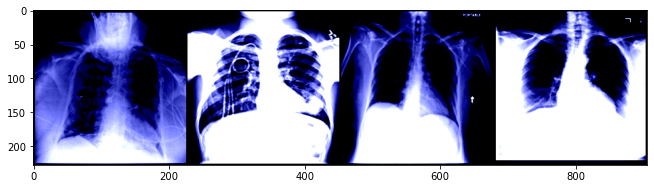

In [7]:
print('test data')
show_img(test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
train data
actual labels: ['Normal', 'Normal', 'Normal', 'Normal']
numerical labels: tensor([2, 2, 2, 2])


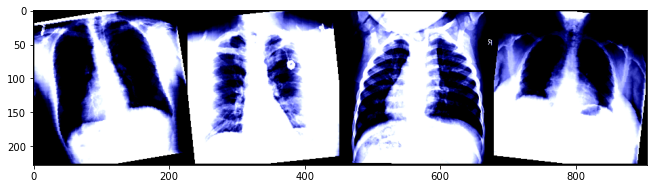

In [8]:
print('train data')
show_img(train_data)

In [9]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([0, 1, 0, 1, 2, 1, 0, 1, 1, 2])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([1, 2, 0, 1, 1, 3, 1, 1, 0, 3])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([1, 2, 1, 1, 1, 1, 2, 2, 3, 2])


In [10]:
print(f'Length of Training: {len(train_data)}')
print(f'Length of Validation: {len(val_data)}')
print(f'Length of Testing: {len(test_data)}')

Length of Training: 21658
Length of Validation: 2708
Length of Testing: 2707


# AlexNet

## Settings

In [29]:
from helper_evaluation import compute_accuracy
from helper_train import train_model

In [30]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

## Define AlexNet

In [31]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [32]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [59]:
# print(model)

## Train (AlexNet)

In [37]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = 10, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/010 | Batch 0000/0265 | Loss: 1.3848
Epoch: 001/010 | Batch 0050/0265 | Loss: 1.0900
Epoch: 001/010 | Batch 0100/0265 | Loss: 0.9704
Epoch: 001/010 | Batch 0150/0265 | Loss: 0.7785
Epoch: 001/010 | Batch 0200/0265 | Loss: 0.7217
Epoch: 001/010 | Batch 0250/0265 | Loss: 0.6389
Epoch: 001/010 | Train: 73.46% | Validation: 72.27%
Time elapsed: 11.78 min
Epoch: 002/010 | Batch 0000/0265 | Loss: 0.5307
Epoch: 002/010 | Batch 0050/0265 | Loss: 0.8519
Epoch: 002/010 | Batch 0100/0265 | Loss: 0.8842
Epoch: 002/010 | Batch 0150/0265 | Loss: 0.5812
Epoch: 002/010 | Batch 0200/0265 | Loss: 0.5178
Epoch: 002/010 | Batch 0250/0265 | Loss: 0.5581
Epoch: 002/010 | Train: 81.44% | Validation: 80.54%
Time elapsed: 23.31 min
Epoch: 003/010 | Batch 0000/0265 | Loss: 0.5593
Epoch: 003/010 | Batch 0050/0265 | Loss: 0.5456
Epoch: 003/010 | Batch 0100/0265 | Loss: 0.4086
Epoch: 003/010 | Batch 0150/0265 | Loss: 0.4851
Epoch: 003/010 | Batch 0200/0265 | Loss: 0.5184
Epoch: 003/010 | Batch 0250/0265

# Evaluation (AlexNet)

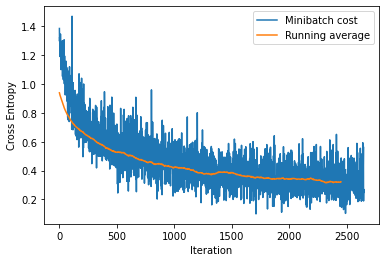

In [38]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

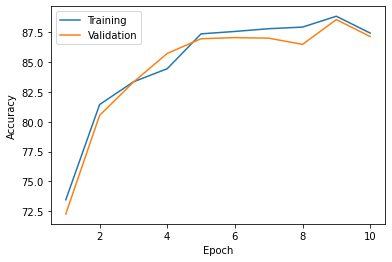

In [39]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 87.34%
Validation ACC: 87.34%
Test ACC: 87.43%


# Import PreTrained AlexNet

In [49]:
model = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Jijimon/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [01:12<00:00, 3.36MB/s]


In [53]:
#fine tune
model.classifier[4] = nn.Linear(4096, 256)
model.classifier[6] = nn.Linear(256, 4)

In [60]:
# print(model)

In [56]:
torch.manual_seed(RANDOM_SEED)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [58]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = 10, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/010 | Batch 0000/0265 | Loss: 1.1438
Epoch: 001/010 | Batch 0050/0265 | Loss: 0.5526
Epoch: 001/010 | Batch 0100/0265 | Loss: 0.5198
Epoch: 001/010 | Batch 0150/0265 | Loss: 0.5161
Epoch: 001/010 | Batch 0200/0265 | Loss: 0.3704
Epoch: 001/010 | Batch 0250/0265 | Loss: 0.5008
Epoch: 001/010 | Train: 85.63% | Validation: 85.83%
Time elapsed: 12.49 min
Epoch: 002/010 | Batch 0000/0265 | Loss: 0.3846
Epoch: 002/010 | Batch 0050/0265 | Loss: 0.4234
Epoch: 002/010 | Batch 0100/0265 | Loss: 0.3937
Epoch: 002/010 | Batch 0150/0265 | Loss: 0.4047
Epoch: 002/010 | Batch 0200/0265 | Loss: 0.3385
Epoch: 002/010 | Batch 0250/0265 | Loss: 0.3583
Epoch: 002/010 | Train: 83.46% | Validation: 82.85%
Time elapsed: 25.54 min
Epoch: 003/010 | Batch 0000/0265 | Loss: 0.3611
Epoch: 003/010 | Batch 0050/0265 | Loss: 0.3136
Epoch: 003/010 | Batch 0100/0265 | Loss: 0.1607
Epoch: 003/010 | Batch 0150/0265 | Loss: 0.4308
Epoch: 003/010 | Batch 0200/0265 | Loss: 0.2257
Epoch: 003/010 | Batch 0250/0265

# Evaluation (pretrained AlexNet)

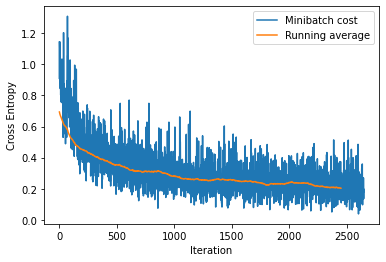

In [61]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [1]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')